# Análisis Exploratorio de Datos (EDA)

Para comenzar con este eda, debemos haber previamente ejecutado el ETL sobre el dataset original de Yelp. Se explicará en la documentación como se creó el dataset a travez de todos los archivos originales, y como se han cruzado los ID.

1. Carga y limpieza inicial
En esta primera etapa, se cargará el archivo meta_df.parquet y se realizará una limpieza inicial del DataFrame. Eliminaremos las columnas que no son relevantes para nuestro análisis y filtraremos las que nos interesan, incluyendo información sobre reseñas, ubicaciones, categorías, calificaciones y otros detalles. Esto nos permitirá enfocarnos en los datos más útiles para nuestro cliente.

In [1]:
import polars as pl
import pygwalker as pyg

from google.oauth2.service_account import Credentials
from google.cloud import storage
import gcsfs
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Configuración de la autenticación y creación de FileSystem
fs = gcsfs.GCSFileSystem(token="credencial_karen_propietario.json")

# Ruta al archivo Parquet que incluye wildcard para múltiples archivos
path = 'gs://bucket-proyecto-final-1/datos-limpios/yelp/meta_df.parquet'


# Lee los archivos Parquet directamente en un DataFrame de Polars
# Nota: Polars puede leer directamente de un path, pero para usar con gcsfs, necesitamos abrir los archivos uno por uno
def read_parquet_files(path):
    files = fs.glob(path)
    frames = [pl.read_parquet(fs.open(file)) for file in files]
    return pl.concat(frames)

df = read_parquet_files(path)

In [3]:
df.schema

Schema([('review_id', String),
        ('user_id', String),
        ('business_id', String),
        ('stars_x', Int64),
        ('useful', Int64),
        ('funny', Int64),
        ('cool', Int64),
        ('text', String),
        ('date', Datetime(time_unit='ns', time_zone=None)),
        ('name', String),
        ('address', String),
        ('city', String),
        ('state', String),
        ('postal_code', String),
        ('latitude', Float64),
        ('longitude', Float64),
        ('stars_y', Float64),
        ('review_count', Int64),
        ('is_open', Int64),
        ('attributes', String),
        ('categories', List(String)),
        ('hours', String)])

In [4]:
#columnas que consideramos utiles para el analisis
columnas_utiles = [
    'review_id', 'user_id', 'business_id', 'stars_x', 'attributes', 'useful', 'funny', 'cool',
    'text', 'date', 'city', 'state', 'latitude', 'longitude', 'categories', 'hours' , 'name', 'review_count'
]

#filtrar las columnas que son utiles
df = df[columnas_utiles]

In [5]:
print(df.head(1))

shape: (1, 18)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ user_id   ┆ business_ ┆ stars_x ┆ … ┆ categorie ┆ hours     ┆ name      ┆ review_co │
│ ---        ┆ ---       ┆ id        ┆ ---     ┆   ┆ s         ┆ ---       ┆ ---       ┆ unt       │
│ str        ┆ str       ┆ ---       ┆ i64     ┆   ┆ ---       ┆ str       ┆ str       ┆ ---       │
│            ┆           ┆ str       ┆         ┆   ┆ list[str] ┆           ┆           ┆ i64       │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ KU_O5udG6z ┆ mh_-eMZ6K ┆ XQfwVwDr- ┆ 3       ┆ … ┆ ["Restaur ┆ {"Monday" ┆ Turning   ┆ 169       │
│ pxOg-VcAEo ┆ 5RLWhZyIS ┆ v0ZS3_Cbb ┆         ┆   ┆ ants",    ┆ : "7:30-1 ┆ Point of  ┆           │
│ dg         ┆ BhwA      ┆ E5Xw      ┆         ┆   ┆ "Breakfas ┆ 5:0",     ┆ North     ┆           │
│            ┆           ┆           ┆         ┆   ┆ t & B…    ┆ "Tuesd…   ┆

2. Estados con más reseñas
En este paso, contaremos el número de reseñas por estado, las ordenaremos de mayor a menor y generaremos un gráfico para visualizar los estados con mayor actividad de reseñas. Este análisis nos ayudará a identificar los mercados más relevantes para la expansión de la cadena de restaurantes.
* Consideraremos los estados que incluyan una buena cantidad de reseñas, ignoraremos las que tienen un numero insignificativo de estas.

In [6]:
import polars as pl
import plotly.express as px

# Filtrar los datos excluyendo registros con "valor incompleto" en el estado
df_filtrado = df.filter(pl.col("state") != "valor incompleto")

# Contar el número de reseñas por estado y obtener latitud y longitud
reseñas_por_estado = (
    df_filtrado.group_by("state")
    .agg(
        pl.count().alias("review_count"),
        pl.first("latitude").alias("latitude"),   # Obtener la primera latitud para cada estado
        pl.first("longitude").alias("longitude")   # Obtener la primera longitud para cada estado
    )
    .sort("review_count", descending=True)
)

# Filtrar los estados con al menos 10,000 reseñas
reseñas_significativas = reseñas_por_estado.filter(pl.col("review_count") >= 10000)

# Mostrar los estados con mayor número de reseñas
print("Estados con más reseñas:")
print(reseñas_significativas)

# Graficar solo los estados con reseñas significativas
fig = px.bar(
    reseñas_significativas.to_dicts(),
    x="state",
    y="review_count",
    title="Estados con Mayor Número de Reseñas",
    labels={"review_count": "Número de Reseñas", "state": "Estado"}
)

# Mostrar la gráfica
fig.show()



C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\2732718963.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("review_count"),


Estados con más reseñas:
shape: (14, 4)
┌───────┬──────────────┬───────────┬─────────────┐
│ state ┆ review_count ┆ latitude  ┆ longitude   │
│ ---   ┆ ---          ┆ ---       ┆ ---         │
│ str   ┆ u32          ┆ f64       ┆ f64         │
╞═══════╪══════════════╪═══════════╪═════════════╡
│ PA    ┆ 1151002      ┆ 40.210196 ┆ -75.223639  │
│ FL    ┆ 885484       ┆ 34.416984 ┆ -119.695556 │
│ TN    ┆ 406893       ┆ 27.941975 ┆ -82.505307  │
│ MO    ┆ 365908       ┆ 39.949529 ┆ -75.152139  │
│ IN    ┆ 356811       ┆ 38.589429 ┆ -90.30764   │
│ …     ┆ …            ┆ …         ┆ …           │
│ AB    ┆ 188924       ┆ 40.079848 ┆ -75.02508   │
│ CA    ┆ 169848       ┆ 32.255834 ┆ -110.96056  │
│ ID    ┆ 155317       ┆ 39.785425 ┆ -86.241454  │
│ DE    ┆ 80736        ┆ 36.144868 ┆ -86.811066  │
│ IL    ┆ 73772        ┆ 39.948949 ┆ -75.169532  │
└───────┴──────────────┴───────────┴─────────────┘


3. En este análisis, identificaremos las categorías de negocios con más reseñas, lo que puede indicar su popularidad y relevancia en el mercado. Filtraremos categorías relacionadas con la industria de alimentos y restaurantes para proporcionar información valiosa para el cliente.

In [7]:
import polars as pl
import plotly.express as px

# Crear un DataFrame simplificado con solo las columnas necesarias
df_simple = df.select(['categories', 'review_count'])

# Expandir la lista de categorías en filas individuales
df_simple = df_simple.explode('categories')

# Filtrar las categorías relevantes relacionadas con la industria de alimentos y restaurantes
categorias_relevantes = [
    'Restaurants', 'Food', 'American (Traditional)', 'American (New)',
    'Breakfast & Brunch', 'Sandwiches', 'Seafood', 'Pizza', 'Coffee & Tea',
    'Italian', 'Burgers', 'Mexican', 'Salad', 'Cocktail Bars'
]
df_simple = df_simple.filter(pl.col("categories").is_in(categorias_relevantes))

# Contar la cantidad de reseñas por categoría
reseñas_por_categoria = (
    df_simple
    .group_by("categories")
    .agg(pl.count().alias("review_count"))
    .sort("review_count", descending=True)
    .head(20)
)

# Convertir a un diccionario para graficar
reseñas_por_categoria_dict = reseñas_por_categoria.to_dicts()

# Graficar las categorías con más reseñas
fig = px.bar(
    reseñas_por_categoria_dict,
    x='categories', 
    y='review_count',
    title='Categorías con Mayor Número de Reseñas (Relevantes)',
    labels={'review_count': 'Número de Reseñas', 'categories': 'Categoría'}
)
fig.show()



C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\3141075361.py:22: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



In [8]:
import polars as pl
import plotly.express as px

# Crear un DataFrame simplificado con solo las columnas necesarias
df_categories = df.select(['categories', 'review_count'])

# Expandir la lista de categorías en filas individuales
df_categories = df_categories.explode('categories')

# Contar la cantidad de reseñas por categoría
reseñas_por_categoria = (
    df_categories
    .group_by("categories")
    .agg(pl.count().alias("review_count"))
    .sort("review_count", descending=True)
    .head(20)
)

# Convertir a un diccionario para graficar
reseñas_por_categoria_dict = reseñas_por_categoria.to_dicts()

# Graficar las categorías con más reseñas
fig = px.bar(
    reseñas_por_categoria_dict,
    x='categories', 
    y='review_count',
    title='Categorías con Mayor Número de Reseñas',
    labels={'review_count': 'Número de Reseñas', 'categories': 'Categoría'}
)
fig.show()

C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\697021722.py:14: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



4. Análisis de Frecuencia de Palabras en las Reseñas
Para entender mejor las reseñas de los clientes, realizamos un análisis de frecuencia de palabras en el texto de las reseñas. Hemos limpiado el texto para eliminar caracteres especiales y convertimos las palabras a minúsculas. Utilizamos CountVectorizer para identificar las palabras más comunes, excluyendo las palabras comunes del idioma inglés (stop words). Esto nos permite centrarnos en los términos que pueden ser más relevantes para analizar la satisfacción del cliente y sus principales preocupaciones.

In [4]:
#analisis de frecuencia de palabras en las resenas

from sklearn.feature_extraction.text import CountVectorizer
import re

#eliminar caracteres especiales y convertir el texto a minusculas
df['text_clean'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x)).lower())

#configurar el countvectorizer para excluir palabras comunes en ingles (stop words)
vectorizer = CountVectorizer(stop_words='english', max_features=50)

#ajustar el vectorizer al texto limpio
X = vectorizer.fit_transform(df['text_clean'])

#obtener las palabras mas frecuentes y sus recuentos
frequencies = zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0))
sorted_frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)

#mostrar las 20 palabras mas comunes
print("Palabras más comunes en las reseñas:")
for word, count in sorted_frequencies[:20]:
    print(f"{word}: {count}")

#graficar las palabras mas comunes
top_words = sorted_frequencies[:20]
words, counts = zip(*top_words)
fig = px.bar(x=words, y=counts, title='Palabras Más Comunes en las Reseñas', labels={'x': 'Palabras', 'y': 'Frecuencia'})
fig.show()


Palabras más comunes en las reseñas:
food: 2704176
good: 2649062
place: 2471876
great: 2272975
just: 1792952
like: 1771210
time: 1693208
service: 1648035
really: 1313537
got: 1037602
nice: 971811
dont: 958351
im: 903784
ordered: 900239
best: 890305
ive: 873296
order: 863527
love: 834292
staff: 819090
did: 790327


### Interpretación de resultados:

* "food" (2.7M veces mencionada): La comida es claramente el tema principal en las reseñas, lo cual es esperado para un restaurante. Es importante analizar el contexto en el que se menciona "food" (positivo o negativo) para entender si los clientes están satisfechos con la calidad de los platos.

* "good" (2.6M veces) y "great" (2.3M veces): Estas palabras sugieren que muchos clientes tienen experiencias positivas en los establecimientos. Se podría profundizar en las frases que rodean estas palabras para conocer qué aspectos específicos (calidad de la comida, servicio, ambiente) se consideran "buenos" o "excelentes".

* "place" (2.4M veces): Los clientes suelen referirse al restaurante en general. Esta palabra, combinada con términos como "nice", "great", o "location", puede ayudar a identificar si la ubicación y el ambiente del restaurante son atractivos para los clientes.

* "service" (1.6M veces): El servicio es un factor crucial para la satisfacción del cliente. Es importante analizar el contexto en el que se menciona "service" para detectar si las menciones son positivas (e.g., "great service") o negativas (e.g., "poor service").

* "ordered", "order" (900K+ veces): Las palabras relacionadas con los pedidos sugieren que los clientes están comentando sobre su experiencia con el proceso de orden. Esto puede incluir la precisión de los pedidos, la rapidez o problemas con la comida solicitada.

* "staff" (819K veces): Los empleados son un componente clave en la experiencia del cliente. Evaluar si las menciones son positivas (e.g., "friendly staff") o negativas (e.g., "rude staff") ayudará a identificar áreas de mejora en el servicio.

* "love", "best", "really": Estas palabras indican fuertes sentimientos positivos, lo que es una buena señal. Es útil revisar las frases completas para entender qué aspectos generan tanto entusiasmo.

___

5. Análisis de Sentimientos en las Reseñas

Para identificar la actitud general en las reseñas, se realizó un análisis de sentimientos utilizando la librería `TextBlob`, la cual evalúa la polaridad de cada comentario:

- **Positivo:** Polaridad mayor a 0.2.
- **Negativo:** Polaridad menor a -0.2.
- **Neutral:** Polaridad entre -0.2 y 0.2.

El objetivo es categorizar las reseñas en estos tres grupos para entender mejor la percepción de los usuarios.

El código utilizado para clasificar los sentimientos y graficar la distribución es el siguiente:


In [5]:
import pandas as pd
from textblob import TextBlob
import plotly.express as px

#tomar una muestra aleatoria del 30% del dataframe
df_muestra = df.sample(frac=0.3, random_state=42)

#funcion para clasificar el sentimiento basado en la polaridad
def clasificar_sentimiento(texto):
    polaridad = TextBlob(texto).sentiment.polarity
    if polaridad > 0.2:
        return 'positivo'
    elif polaridad < -0.2:
        return 'negativo'
    else:
        return 'neutral'

#aplicar la funcion de clasificacion de sentimientos a la muestra
df_muestra['sentimiento'] = df_muestra['text'].apply(clasificar_sentimiento)

#verificar la cantidad de resenas positivas, negativas y neutrales
sentimientos_contados = df_muestra['sentimiento'].value_counts()
print("Distribución de Sentimientos en las Reseñas:")
print(sentimientos_contados)

#graficar la distribucion de sentimientos
fig = px.bar(sentimientos_contados, x=sentimientos_contados.index, y=sentimientos_contados.values,
             title='Distribución de Sentimientos en las Reseñas (Muestra de un %)',
             labels={'x': 'Sentimiento', 'y': 'Cantidad de Reseñas'})
fig.show()


Distribución de Sentimientos en las Reseñas:
sentimiento
positivo    902368
neutral     581130
negativo     41295
Name: count, dtype: int64


6. Análisis de Categorías según el Sentimiento de las Reseñas

En esta sección, analizaremos la relación entre el tipo de sentimiento en las reseñas (positivo, neutral, negativo) y las categorías de los negocios. Este análisis nos permitirá identificar cuáles son las categorías que tienden a recibir mejores o peores reseñas, lo cual puede ser útil para priorizar estrategias de marketing o tomar decisiones operativas.

El análisis consiste en:
- Filtrar los datos por el tipo de sentimiento (positivo, neutral, negativo).
- Contar la cantidad de negocios para cada categoría en cada grupo de sentimiento.
- Visualizar las 10 categorías más comunes en función del sentimiento, con el fin de identificar patrones de satisfacción o insatisfacción entre los clientes.


In [6]:
import pandas as pd
import plotly.express as px

#filtrar los datos por tipo de sentimiento
df_positivo = df_muestra[df_muestra['sentimiento'] == 'positivo']
df_neutral = df_muestra[df_muestra['sentimiento'] == 'neutral']
df_negativo = df_muestra[df_muestra['sentimiento'] == 'negativo']

#analisis de categorias
#contar la cantidad de negocios por categoria y sentimiento
def contar_categorias(df, tipo_sentimiento):
    categorias_exploded = df.explode('categories')
    categorias_contadas = categorias_exploded['categories'].value_counts().reset_index()
    categorias_contadas.columns = ['category', 'count']
    categorias_contadas['sentimiento'] = tipo_sentimiento
    return categorias_contadas

categorias_positivas = contar_categorias(df_positivo, 'positivo')
categorias_neutrales = contar_categorias(df_neutral, 'neutral')
categorias_negativas = contar_categorias(df_negativo, 'negativo')

#combinar los resultados en un solo dataframe
categorias_sentimiento = pd.concat([categorias_positivas, categorias_neutrales, categorias_negativas])

#graficar las 10 categorias mas comunes por sentimiento
fig = px.bar(categorias_sentimiento[categorias_sentimiento['category'].isin(
    categorias_sentimiento.groupby('category')['count'].sum().nlargest(10).index)],
    x='category', y='count', color='sentimiento', 
    title='Top 10 Categorías según el Sentimiento de las Reseñas',
    labels={'count': 'Cantidad de Negocios', 'category': 'Categoría'},
    barmode='group')
fig.show()


7. Análisis de la Distribución Geográfica de las Reseñas según el Sentimiento

Este análisis busca entender la distribución geográfica de las reseñas, considerando el tipo de sentimiento (positivo, neutral, negativo) en cada estado. Con esto, podemos identificar si existen diferencias significativas en la satisfacción de los clientes dependiendo de la ubicación geográfica.

Los pasos para este análisis son:
- Filtrar los datos por el tipo de sentimiento para agrupar las reseñas en positivo, neutral y negativo.
- Contar la cantidad de reseñas por estado en cada grupo de sentimiento.
- Visualizar los resultados para analizar la variación en la cantidad de reseñas y sentimientos a lo largo de diferentes estados.


In [7]:
#analisis de distribucion geografica
#contar la cantidad de resenas por estado y sentimiento
def contar_por_estado(df, tipo_sentimiento):
    estados_contados = df['state'].value_counts().reset_index()
    estados_contados.columns = ['state', 'count']
    estados_contados['sentimiento'] = tipo_sentimiento
    return estados_contados

estados_positivos = contar_por_estado(df_positivo, 'positivo')
estados_neutrales = contar_por_estado(df_neutral, 'neutral')
estados_negativos = contar_por_estado(df_negativo, 'negativo')

#combinar los resultados en un solo dataframe
estados_sentimiento = pd.concat([estados_positivos, estados_neutrales, estados_negativos])

#graficar la distribucion de resenas por estado y sentimiento
fig = px.bar(estados_sentimiento, x='state', y='count', color='sentimiento',
             title='Distribución de Reseñas por Estado y Sentimiento',
             labels={'count': 'Cantidad de Reseñas', 'state': 'Estado'},
             barmode='group')
fig.show()


8. Análisis de Servicios o Características y su Relación con el Sentimiento

En esta sección, exploraremos la relación entre los servicios o características de los negocios (representados en la columna `attributes`) y el sentimiento de las reseñas. La columna `attributes` contiene información valiosa sobre las características de cada negocio, como si permiten mascotas, ofrecen Wi-Fi gratis, tienen música en vivo, entre otros.

Para este análisis:
- Expandiremos la columna `attributes` para convertir los datos en un formato manejable.
- Filtraremos los negocios en función del sentimiento de las reseñas (positivo, neutral y negativo).
- Contaremos la frecuencia de los atributos en cada grupo de sentimiento.
- Graficaremos los atributos más comunes para ver si algunos están asociados con reseñas más positivas o negativas.

El objetivo es identificar qué características o servicios están vinculados a una percepción más favorable de los negocios, lo que puede ayudar a la cadena de restaurantes a decidir qué servicios ofrecer para mejorar la experiencia del cliente.


In [8]:
import ast

def expandir_atributos(df):
    #verificar que los valores sean validos y no 'valor incompleto'
    df['attributes'] = df['attributes'].apply(
        lambda x: ast.literal_eval(x) if pd.notnull(x) and isinstance(x, str) and x != 'valor incompleto' else {}
    )
    
    #expandir el diccionario de atributos en columnas separadas
    atributos_expandidos = df['attributes'].apply(pd.Series)
    df_expanded = pd.concat([df, atributos_expandidos], axis=1)
    return df_expanded

#expandir los atributos en el dataframe original
df_expanded = expandir_atributos(df_muestra)

#continuar con el analisis segun el sentimiento
df_positivo = df_expanded[df_expanded['sentimiento'] == 'positivo']
df_neutral = df_expanded[df_expanded['sentimiento'] == 'neutral']
df_negativo = df_expanded[df_expanded['sentimiento'] == 'negativo']


10. Análisis de la Distribución Temporal de las Reseñas

Este análisis examina cuándo los clientes tienden a dejar reseñas en función del día de la semana y la hora del día. Al agregar columnas que representan el día y la hora, podemos identificar los patrones temporales de actividad en las reseñas. Esto proporciona información sobre los momentos de mayor interacción con los clientes, lo que puede ser útil para optimizar estrategias de marketing o gestión de la operación en función de los días y horarios con mayor actividad.

In [9]:
import polars as pl

# Crear nuevas columnas con el día de la semana, hora del día y año directamente de la columna `date`
df = df.with_columns([
    pl.col("date").dt.weekday().alias("day_of_week"),  # Día de la semana (0=Lunes, 6=Domingo)
    pl.col("date").dt.hour().alias("hour_of_day"),     # Hora del día
    pl.col("date").dt.year().alias("year")             # Año
])


In [10]:
import plotly.express as px

# Contar la cantidad de reseñas por día de la semana
resenas_por_dia = (
    df.group_by("day_of_week")
    .agg(pl.count().alias("count"))
    .sort("day_of_week")
)

# Graficar directamente con Plotly Express
fig_dia = px.bar(resenas_por_dia.to_dicts(), x='day_of_week', y='count',
                 title='Distribución de Reseñas por Día de la Semana',
                 labels={'count': 'Cantidad de Reseñas', 'day_of_week': 'Día de la Semana'})
fig_dia.show()


C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\3438887298.py:6: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



In [11]:
# Contar la cantidad de reseñas por hora del día
resenas_por_hora = (
    df.group_by("hour_of_day")
    .agg(pl.count().alias("count"))
    .sort("hour_of_day")
)

# Graficar directamente con Plotly Express
fig_hora = px.bar(resenas_por_hora.to_dicts(), x='hour_of_day', y='count',
                  title='Distribución de Reseñas por Hora del Día',
                  labels={'count': 'Cantidad de Reseñas', 'hour_of_day': 'Hora del Día'})
fig_hora.show()


C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\2227376188.py:4: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



In [12]:
import polars as pl
import plotly.express as px

# Crear un nuevo DataFrame con solo las columnas 'date' y 'review_count'
df_ano_reseñas = df.select([
    pl.col("date").dt.year().alias("year"),  # Extraer el año
    pl.lit(1).alias("review_count")            # Contar cada reseña como 1
])

# Agrupar por año y contar las reseñas
df_ano_reseñas = df_ano_reseñas.group_by("year").agg(
    pl.sum("review_count").alias("total_reviews")  # Sumar el conteo de reseñas por año
).sort("year")  # Ordenar por año

# Convertir a un formato adecuado para Plotly
df_ano_reseñas_pd = df_ano_reseñas.to_pandas()

# Graficar la secuencia de reseñas por año
fig = px.line(df_ano_reseñas_pd, x='year', y='total_reviews',
              title='Cantidad de Reseñas por Año',
              labels={'total_reviews': 'Cantidad de Reseñas', 'year': 'Año'},
              markers=True)  # Usar marcadores para visualizar puntos de datos

# Mostrar la gráfica
fig.show()


11. Análisis de Palabras Comunes en las Reseñas Positivas y Negativas

Este análisis identifica las palabras más comunes en las reseñas positivas y negativas, excluyendo palabras vacías (stopwords) que no aportan significado. Al filtrar y contar las palabras más frecuentes en cada tipo de sentimiento, podemos entender los aspectos más destacados tanto en las experiencias positivas como en las negativas de los clientes. Esto ayuda a resaltar los puntos fuertes y las áreas de mejora según la opinión de los usuarios.

In [11]:
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import plotly.express as px
import nltk

#descargar las stopwords en caso de no tenerlas
nltk.download('stopwords')

#lista de stopwords en ingles
stop_words = set(stopwords.words('english'))

#funcion para extraer palabras comunes de las resenas por sentimiento, excluyendo stopwords
def extraer_palabras_comunes(df, sentimiento, top_n=20):
    #filtrar las resenas segun el sentimiento
    df_sentimiento = df[df['sentimiento'] == sentimiento]
    
    #combinar todos los textos de resenas en una sola cadena
    texto_completo = ' '.join(df_sentimiento['text_clean'].dropna().values)
    
    #filtrar palabras que no sean stopwords
    palabras = [palabra for palabra in texto_completo.split() if palabra.lower() not in stop_words]
    
    #contar las palabras mas comunes
    palabras_comunes = Counter(palabras)
    
    #seleccionar las top_n palabras mas comunes
    palabras_comunes_df = pd.DataFrame(palabras_comunes.most_common(top_n), columns=['palabra', 'frecuencia'])
    palabras_comunes_df['sentimiento'] = sentimiento
    
    return palabras_comunes_df

#extraer palabras comunes para resenas positivas y negativas
palabras_positivas = extraer_palabras_comunes(df_muestra, 'positivo', top_n=20)
palabras_negativas = extraer_palabras_comunes(df_muestra, 'negativo', top_n=20)

#combinar los resultados en un solo dataframe
palabras_comunes = pd.concat([palabras_positivas, palabras_negativas])

#graficar las palabras mas comunes por sentimiento
fig_palabras = px.bar(palabras_comunes, x='palabra', y='frecuencia', color='sentimiento',
                      title='Aspectos Positivos y Negativos en las Reseñas',
                      labels={'frecuencia': 'Frecuencia de Palabras', 'palabra': 'Palabra'},
                      barmode='group')
fig_palabras.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


9. Análisis de Estados con Menciones de Categorias Clave Relacionadas con la comida rapida y la comida de mar

En este análisis, identificamos locales que cuenten con las categorias mas relevantes para el cliente, como lo son "Seafood" y "Fast Food". Filtramos las locales para verificar si contienen estas categorias y luego analizamos la distribución por estado. Esto nos permite identificar las regiones con mayor interés de la poblacion en consumir comida rapida y comida de mar , ayudando al cliente a tomar decisiones informadas sobre dónde establecer su negocio.

In [13]:
import polars as pl
import plotly.express as px

# Función para contar reseñas relacionadas con comida rápida por estado
def count_fastfood_reviews_by_state(df):
    results = {}
    
    # Obtener estados únicos
    unique_states = df['state'].unique().to_list()

    for state in unique_states:
        # Filtrar el DataFrame por el estado actual y la categoría "Fast Food"
        state_df = df.filter(
            (pl.col("state") == state) &
            (pl.col("categories").list.contains("Fast Food"))
        )
        
        # Contar las reseñas en los locales de comida rápida
        fastfood_count = state_df.height  # Número total de reseñas en el estado para "Fast Food"
        
        results[state] = fastfood_count

    return results

# Supongamos que df ya está definido en tu entorno

# Contar reseñas de comida rápida en cada estado
fastfood_reviews_count = count_fastfood_reviews_by_state(df)

# Convertir el resultado en un DataFrame usando una lista de tuplas
fastfood_reviews_df = pl.DataFrame(list(fastfood_reviews_count.items()), schema=["state", "count"])

# Obtener el top 10 estados con más reseñas de comida rápida
top_10_fastfood_reviews = fastfood_reviews_df.sort("count", descending=True).head(10)

# Convertir a pandas para graficar
top_10_fastfood_reviews_pd = top_10_fastfood_reviews.to_pandas()

# Crear un gráfico de barras usando Plotly Express
fig = px.bar(top_10_fastfood_reviews_pd, 
             x='count', 
             y='state', 
             title='Top 10 Estados con más Reseñas de Comida Rápida',
             labels={'count': 'Número de Reseñas sobre Comida Rápida', 'state': 'Estado'},
             orientation='h',  # Gráfico horizontal
             color='count',  # Colorear según el número de reseñas
             color_continuous_scale=px.colors.sequential.Blugrn)  # Escala de colores

# Mostrar el gráfico
fig.show()



C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\3658661641.py:31: DataOrientationWarning:

Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.



In [14]:
import polars as pl
import plotly.express as px

# Lista de palabras clave en inglés relacionadas con mariscos
seafood_keywords = [
    "seafood", "fish", "shrimp", "lobster", "crab", "oyster",
    "clam", "mussels", "scallops", "cuttlefish", "squid", "octopus",
    "prawn", "salmon", "tuna", "cod", "haddock", "bass", "trout",
    "caviar", "anchovy", "mackerel", "perch", "sardine"
]

# Función para contar reseñas relacionadas con mariscos por estado
def count_seafood_reviews_by_state(df, keywords):
    pattern = "|".join(keywords)  # Crear el patrón de búsqueda
    results = {}
    
    # Obtener estados únicos
    unique_states = df['state'].unique().to_list()

    for state in unique_states:
        # Filtrar el DataFrame por el estado actual
        state_df = df.filter(pl.col("state") == state)
        
        # Contar las reseñas relacionadas con mariscos
        seafood_count = state_df.filter(
            pl.col("text").str.to_lowercase().str.contains(pattern)
        ).height
        
        results[state] = seafood_count

    return results

# Supongamos que df ya está definido en tu entorno

# Contar reseñas de mariscos en cada estado
seafood_reviews_count = count_seafood_reviews_by_state(df, seafood_keywords)

# Convertir el resultado en un DataFrame usando una lista de tuplas
seafood_reviews_df = pl.DataFrame(list(seafood_reviews_count.items()), schema=["state", "count"])

# Obtener el top 10 estados con más reseñas de mariscos
top_10_seafood_reviews = seafood_reviews_df.sort("count", descending=True).head(10)

# Convertir a pandas para graficar
top_10_seafood_reviews_pd = top_10_seafood_reviews.to_pandas()

# Crear un gráfico de barras usando Plotly Express
fig = px.bar(top_10_seafood_reviews_pd, 
             x='count', 
             y='state', 
             title='Top 10 Estados con más Reseñas de Mariscos',
             labels={'count': 'Número de Reseñas sobre Mariscos', 'state': 'Estado'},
             orientation='h',  # Gráfico horizontal
             color='count',  # Colorear según el número de reseñas
             color_continuous_scale=px.colors.sequential.Blugrn)  # Escala de colores

# Mostrar el gráfico
fig.show()


C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\4216167537.py:39: DataOrientationWarning:

Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.



## Conclusiones

* Teniendo en cuenta los graficos se puede observar una clara tendencia de los estados de Pensilvania (PA), Florida (FL) y Tenneesse (TN) tanto por la comida rapida como por la comida de mar por lo cual se realizara un analisis mas profundo a estos tres estados para dar sugerencias mas claras al cliente

# Filtrado por estado

In [15]:
# Filtrar el DataFrame original por cada estado
df_pensilvania = df.filter(pl.col("state") == "PA")
df_florida = df.filter(pl.col("state") == "FL")
df_tenesse = df.filter(pl.col("state") == "TN")


In [16]:
# Confirmación
print(df_pensilvania.head(1))
print(df_pensilvania.shape)


shape: (1, 21)
┌────────────┬────────────┬────────────┬─────────┬───┬────────────┬────────────┬────────────┬──────┐
│ review_id  ┆ user_id    ┆ business_i ┆ stars_x ┆ … ┆ review_cou ┆ day_of_wee ┆ hour_of_da ┆ year │
│ ---        ┆ ---        ┆ d          ┆ ---     ┆   ┆ nt         ┆ k          ┆ y          ┆ ---  │
│ str        ┆ str        ┆ ---        ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i32  │
│            ┆            ┆ str        ┆         ┆   ┆ i64        ┆ i8         ┆ i8         ┆      │
╞════════════╪════════════╪════════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════╡
│ KU_O5udG6z ┆ mh_-eMZ6K5 ┆ XQfwVwDr-v ┆ 3       ┆ … ┆ 169        ┆ 6          ┆ 22         ┆ 2018 │
│ pxOg-VcAEo ┆ RLWhZyISBh ┆ 0ZS3_CbbE5 ┆         ┆   ┆            ┆            ┆            ┆      │
│ dg         ┆ wA         ┆ Xw         ┆         ┆   ┆            ┆            ┆            ┆      │
└────────────┴────────────┴────────────┴─────────┴───┴────────────┴─────────

In [17]:
print(df_florida.head(1))
print(df_florida.shape)

shape: (1, 21)
┌────────────┬────────────┬────────────┬─────────┬───┬────────────┬────────────┬────────────┬──────┐
│ review_id  ┆ user_id    ┆ business_i ┆ stars_x ┆ … ┆ review_cou ┆ day_of_wee ┆ hour_of_da ┆ year │
│ ---        ┆ ---        ┆ d          ┆ ---     ┆   ┆ nt         ┆ k          ┆ y          ┆ ---  │
│ str        ┆ str        ┆ ---        ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i32  │
│            ┆            ┆ str        ┆         ┆   ┆ i64        ┆ i8         ┆ i8         ┆      │
╞════════════╪════════════╪════════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════╡
│ pUycOfUwM8 ┆ 59MxRhNVhU ┆ gebiRewfie ┆ 3       ┆ … ┆ 488        ┆ 1          ┆ 7          ┆ 2016 │
│ vqX7KjRRhU ┆ 9MYndMkz0w ┆ Sdtt17PTW6 ┆         ┆   ┆            ┆            ┆            ┆      │
│ EA         ┆ tw         ┆ Zg         ┆         ┆   ┆            ┆            ┆            ┆      │
└────────────┴────────────┴────────────┴─────────┴───┴────────────┴─────────

In [18]:
print(df_tenesse.head(1))
print(df_tenesse.shape)

shape: (1, 21)
┌────────────┬────────────┬────────────┬─────────┬───┬────────────┬────────────┬────────────┬──────┐
│ review_id  ┆ user_id    ┆ business_i ┆ stars_x ┆ … ┆ review_cou ┆ day_of_wee ┆ hour_of_da ┆ year │
│ ---        ┆ ---        ┆ d          ┆ ---     ┆   ┆ nt         ┆ k          ┆ y          ┆ ---  │
│ str        ┆ str        ┆ ---        ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i32  │
│            ┆            ┆ str        ┆         ┆   ┆ i64        ┆ i8         ┆ i8         ┆      │
╞════════════╪════════════╪════════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════╡
│ u2vzZaOqJ2 ┆ NDZvyYHTUW ┆ CLEWowfkj- ┆ 5       ┆ … ┆ 55         ┆ 1          ┆ 0          ┆ 2016 │
│ feRshaaF1d ┆ Wu-kqgQzzD ┆ wKYJlQDqT1 ┆         ┆   ┆            ┆            ┆            ┆      │
│ oQ         ┆ GQ         ┆ aw         ┆         ┆   ┆            ┆            ┆            ┆      │
└────────────┴────────────┴────────────┴─────────┴───┴────────────┴─────────

In [19]:
import polars as pl
import pandas as pd
import plotly.express as px

# Lista de palabras clave en inglés relacionadas con mariscos
seafood_keywords = [
    "seafood", "fish", "shrimp", "lobster", "crab", "oyster",
    "clam", "mussels", "scallops", "cuttlefish", "squid", "octopus",
    "prawn", "salmon", "tuna", "cod", "haddock", "bass", "trout",
    "caviar", "anchovy", "mackerel", "perch", "sardine"
]

# Función para contar reseñas relacionadas con mariscos
def count_seafood_reviews(df, keywords):
    pattern = "|".join(keywords)  # Crear el patrón de búsqueda
    return df.filter(
        pl.col("text").str.to_lowercase().str.contains(pattern)
    ).height

# Contar reseñas de mariscos en cada DataFrame
num_seafood_reviews_pa = count_seafood_reviews(df_pensilvania, seafood_keywords)
num_seafood_reviews_fl = count_seafood_reviews(df_florida, seafood_keywords)
num_seafood_reviews_tn = count_seafood_reviews(df_tenesse, seafood_keywords)

# Crear un DataFrame de Pandas para Plotly
seafood_reviews_data = {
    "Estado": ["Pensilvania", "Florida", "Tennessee"],
    "Reseñas de Mariscos": [num_seafood_reviews_pa, num_seafood_reviews_fl, num_seafood_reviews_tn]
}
seafood_reviews_df = pd.DataFrame(seafood_reviews_data)

# Crear gráfico de pastel
fig = px.pie(seafood_reviews_df, values='Reseñas de Mariscos', names='Estado', title='Reseñas de Mariscos por Estado')
fig.show()


In [20]:
# Función para obtener los 5 locales más frecuentes relacionados con mariscos, incluyendo la categoría
def top_3_seafood_places(df, keywords):
    pattern = "|".join(keywords)  # Crear el patrón de búsqueda
    filtered_df = df.filter(
        pl.col("text").str.to_lowercase().str.contains(pattern)  # Filtrar reseñas de mariscos
    )
    
    # Agrupar por 'name', contar las ocurrencias, obtener la categoría y ordenar
    top_places = (
        filtered_df
        .group_by("name")
        .agg([
            pl.count().alias("review_count"),
            pl.col("categories").first().alias("category")  # Tomar la primera categoría asociada al local
        ])
        .sort("review_count", descending=True)
        .limit(4)  # Seleccionar los 5 más frecuentes
    )
    return top_places

In [21]:
# Obtener los 3 locales más frecuentes con categoría para cada estado
top_3_pensilvania = top_3_seafood_places(df_pensilvania, seafood_keywords)

# Filtrar los resultados para quedarnos solo con aquellos que contengan 'Seafood' en las categorías
top_3_pensilvania_seafood = top_3_pensilvania.filter(
    pl.col("category").list.contains("Seafood")
)

# Imprimir los resultados filtrados
print("Top 3 locales de mariscos en Pensilvania que contienen 'Seafood' en categorías:")
print(top_3_pensilvania_seafood)

C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\2368994145.py:13: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



Top 3 locales de mariscos en Pensilvania que contienen 'Seafood' en categorías:
shape: (3, 3)
┌─────────────────────────────┬──────────────┬─────────────────────────────────┐
│ name                        ┆ review_count ┆ category                        │
│ ---                         ┆ ---          ┆ ---                             │
│ str                         ┆ u32          ┆ list[str]                       │
╞═════════════════════════════╪══════════════╪═════════════════════════════════╡
│ Luke                        ┆ 2236         ┆ ["German", "Restaurants", … "B… │
│ Drago's Seafood Restaurant  ┆ 1820         ┆ ["Restaurants", "Seafood"]      │
│ Brophy Bros - Santa Barbara ┆ 1371         ┆ ["Cocktail Bars", "Fish & Chip… │
└─────────────────────────────┴──────────────┴─────────────────────────────────┘


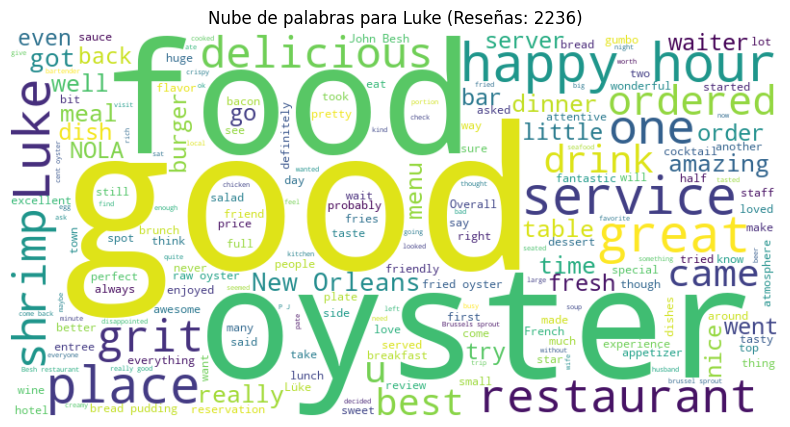

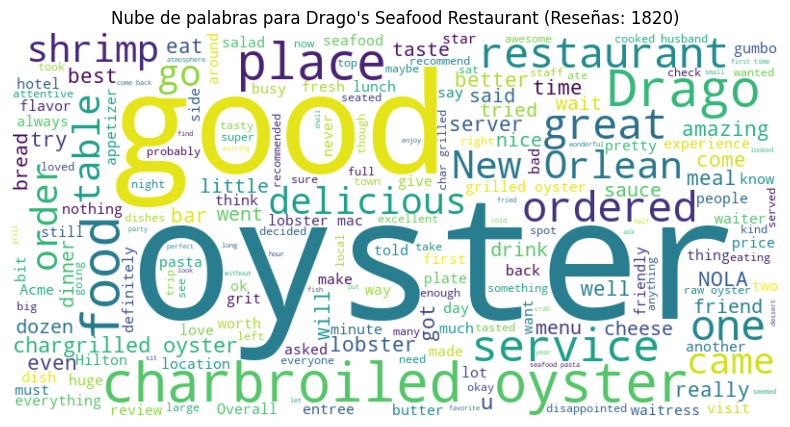

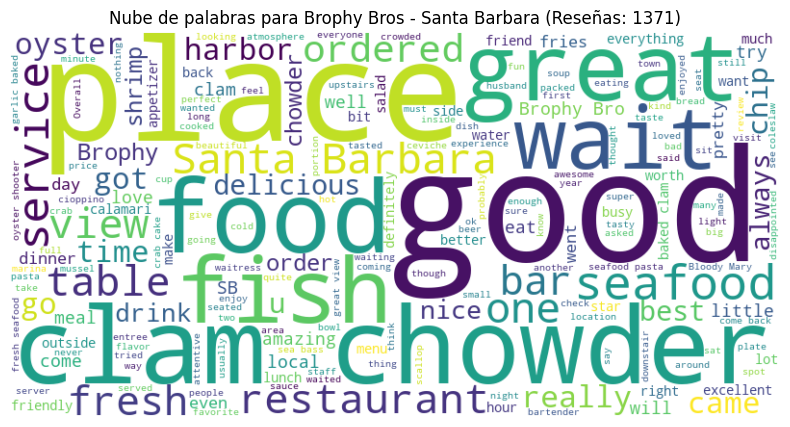

In [22]:
import polars as pl
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear una nube de palabras para cada uno de los 3 restaurantes
for idx, row in enumerate(top_3_pensilvania_seafood.iter_rows()):
    name = row[0]
    review_count = row[1]
    category = row[2]
    
    # Filtrar el DataFrame original para obtener las reseñas del restaurante actual
    reviews = df_pensilvania.filter(pl.col("name") == name)

    # Concatenar todas las reseñas en un solo texto
    text = ' '.join(reviews['text'].to_list())
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Sin ejes
    plt.title(f"Nube de palabras para {name} (Reseñas: {review_count})")
    plt.show()

In [23]:
# Obtener los 3 locales más frecuentes con categoría para cada estado
top_3_florida = top_3_seafood_places(df_florida, seafood_keywords)

# Filtrar los resultados para quedarnos solo con aquellos que contengan 'Seafood' en las categorías
top_3_florida_seafood = top_3_florida.filter(
    pl.col("category").list.contains("Seafood")
)

print("\nTop 3 locales de mariscos en Florida que contienen 'Seafood' en categorías:")
print(top_3_florida_seafood)

C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\2368994145.py:13: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.




Top 3 locales de mariscos en Florida que contienen 'Seafood' en categorías:
shape: (3, 3)
┌───────────────┬──────────────┬─────────────────────────────────┐
│ name          ┆ review_count ┆ category                        │
│ ---           ┆ ---          ┆ ---                             │
│ str           ┆ u32          ┆ list[str]                       │
╞═══════════════╪══════════════╪═════════════════════════════════╡
│ Oceana Grill  ┆ 2481         ┆ ["Restaurants", "Seafood", … "… │
│ Oyster House  ┆ 1144         ┆ ["Restaurants", "Steakhouses",… │
│ Bourbon House ┆ 934          ┆ ["Restaurants", "Cajun/Creole"… │
└───────────────┴──────────────┴─────────────────────────────────┘


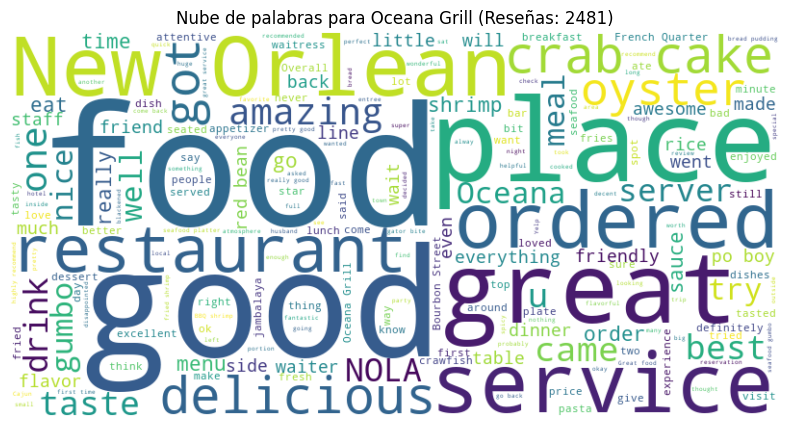

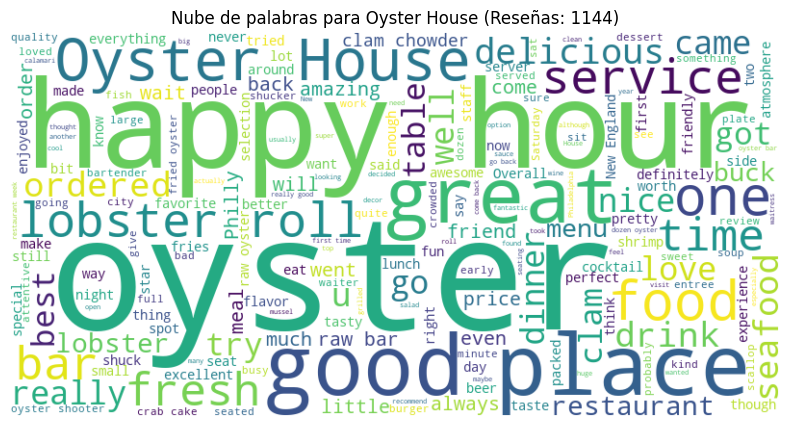

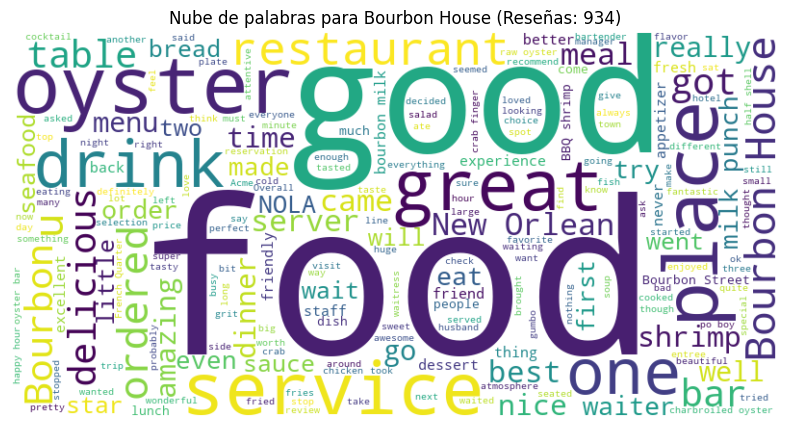

In [24]:
# Crear una nube de palabras para cada uno de los 3 restaurantes
for idx, row in enumerate(top_3_florida_seafood.iter_rows()):
    name = row[0]
    review_count = row[1]
    category = row[2]
    
    # Filtrar el DataFrame original para obtener las reseñas del restaurante actual
    reviews = df_florida.filter(pl.col("name") == name)

    # Concatenar todas las reseñas en un solo texto
    text = ' '.join(reviews['text'].to_list())
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Sin ejes
    plt.title(f"Nube de palabras para {name} (Reseñas: {review_count})")
    plt.show()

In [25]:
# Obtener los 3 locales más frecuentes con categoría para cada estado
top_3_tennessee = top_3_seafood_places(df_tenesse, seafood_keywords)

# Filtrar los resultados para quedarnos solo con aquellos que contengan 'Seafood' en las categorías
top_3_tennessee_seafood = top_3_tennessee.filter(
    pl.col("category").list.contains("Seafood")
)

# Eliminar el tercer resultado específico (St. Elmo Steak House)
top_3_tennessee_seafood = top_3_tennessee_seafood.filter(
    pl.col("name") != "St. Elmo Steak House"
)

print("\nTop 3 locales de mariscos en Tennessee que contienen 'Seafood' en categorías (sin St. Elmo Steak House):")
print(top_3_tennessee_seafood)


C:\Users\KAREN\AppData\Local\Temp\ipykernel_1340\2368994145.py:13: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.




Top 3 locales de mariscos en Tennessee que contienen 'Seafood' en categorías (sin St. Elmo Steak House):
shape: (3, 3)
┌─────────────────────────────────┬──────────────┬─────────────────────────────────┐
│ name                            ┆ review_count ┆ category                        │
│ ---                             ┆ ---          ┆ ---                             │
│ str                             ┆ u32          ┆ list[str]                       │
╞═════════════════════════════════╪══════════════╪═════════════════════════════════╡
│ GW Fins                         ┆ 1107         ┆ ["Seafood", "Gluten-Free", … "… │
│ Santa Barbara Shellfish Compan… ┆ 1089         ┆ ["Live/Raw Food", "Restaurants… │
│ Frenchy's Rockaway Grill        ┆ 806          ┆ ["Sandwiches", "American (Trad… │
└─────────────────────────────────┴──────────────┴─────────────────────────────────┘


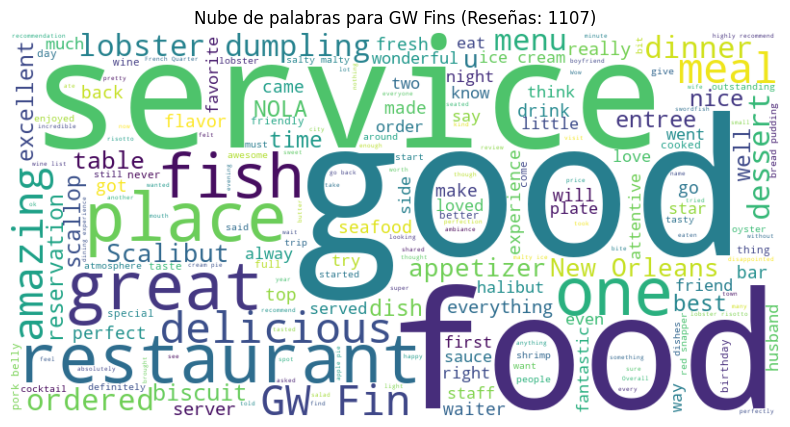

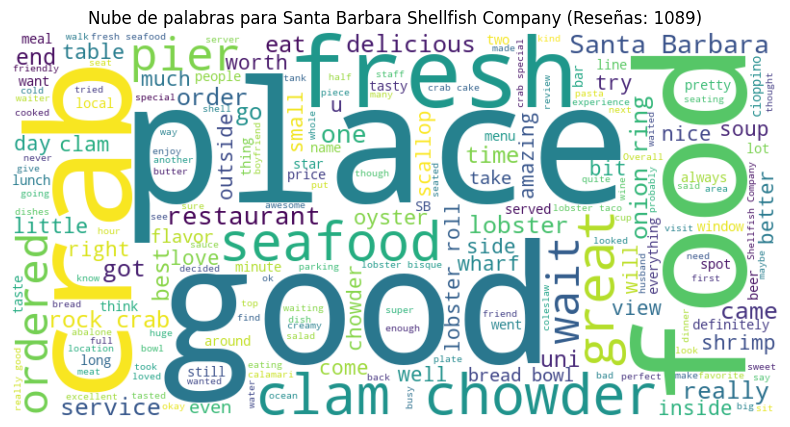

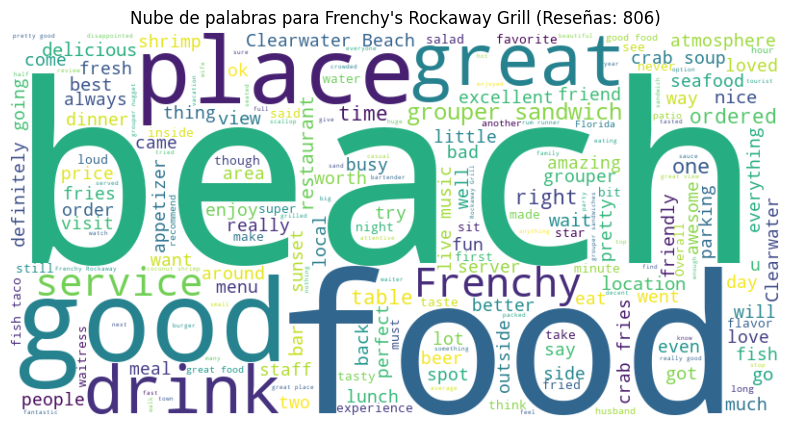

In [26]:
# Crear una nube de palabras para cada uno de los 3 restaurantes
for idx, row in enumerate(top_3_tennessee_seafood.iter_rows()):
    name = row[0]
    review_count = row[1]
    category = row[2]
    
    # Filtrar el DataFrame original para obtener las reseñas del restaurante actual
    reviews = df_tenesse.filter(pl.col("name") == name)

    # Concatenar todas las reseñas en un solo texto
    text = ' '.join(reviews['text'].to_list())
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Sin ejes
    plt.title(f"Nube de palabras para {name} (Reseñas: {review_count})")
    plt.show()

In [27]:
# Filtrar el DataFrame original para obtener solo los locales del top 3
top_3_names_tennessee = top_3_tennessee_seafood['name'].to_list()

# Calcular el promedio de estrellas para los locales del top 3 en Tennessee
promedio_estrellas_tennessee = df_tenesse.filter(
    pl.col('name').is_in(top_3_names_tennessee)
).group_by('name').agg(
    pl.col('stars_x').mean().alias('promedio_estrellas')
)

# Mostrar los resultados
print("Promedio de estrellas en los locales del top 3 en Tennessee:")
print(promedio_estrellas_tennessee)

Promedio de estrellas en los locales del top 3 en Tennessee:
shape: (3, 2)
┌─────────────────────────────────┬────────────────────┐
│ name                            ┆ promedio_estrellas │
│ ---                             ┆ ---                │
│ str                             ┆ f64                │
╞═════════════════════════════════╪════════════════════╡
│ Santa Barbara Shellfish Compan… ┆ 3.980492           │
│ GW Fins                         ┆ 4.552126           │
│ Frenchy's Rockaway Grill        ┆ 3.971724           │
└─────────────────────────────────┴────────────────────┘


In [28]:
import polars as pl
import plotly.graph_objects as go

# --- Para Tennessee ---
# Filtrar el DataFrame original para obtener solo los locales de Tennessee
top_3_names_tennessee = top_3_tennessee_seafood['name'].to_list()

promedio_estrellas_tennessee = df.filter(
    pl.col('name').is_in(top_3_names_tennessee)
).group_by('name').agg(
    pl.col('stars_x').mean().alias('promedio_estrellas')
)

# Convertir a pandas para la gráfica
promedio_estrellas_tennessee_pd = promedio_estrellas_tennessee.to_pandas()

# Crear la figura para Tennessee
fig_tennessee = go.Figure()

# Añadir las representaciones de lunas para Tennessee
for index, row in promedio_estrellas_tennessee_pd.iterrows():
    stars = row['promedio_estrellas']
    name = row['name']
    
    # Calcular lunas llenas, medias y menguantes
    full_moons = int(stars)  # Lunas llenas
    if stars % 1 >= 0.5:
        half_moon = 1  # Luna media
        waning_moon = 0  # Sin luna menguante
    elif stars % 1 >= 0.1:
        half_moon = 0  # No luna media
        waning_moon = 1  # Luna menguante
    else:
        half_moon = 0  # No luna media
        waning_moon = 0  # Sin luna menguante

    empty_moons = 5 - full_moons - half_moon - waning_moon  # Lunas vacías

    stars_representation = '🌕' * full_moons + ('🌗' * half_moon) + ('🌘' * waning_moon) + ('🌑' * empty_moons)

    fig_tennessee.add_trace(go.Bar(
        x=[name],
        y=[stars],
        name=stars_representation,
        hovertemplate=f'{name}: {stars:.2f} Estrellas<br>{stars_representation}',
        text=stars_representation,
        textposition='inside'
    ))

# Ajustes del layout para Tennessee
fig_tennessee.update_layout(
    title='Promedio de Estrellas por Restaurante en Tennessee',
    xaxis_title='Restaurante',
    yaxis_title='Promedio de Estrellas',
    yaxis=dict(range=[0, 5]),
    showlegend=False,
    margin=dict(l=40, r=40, t=40, b=40)
)

# Mostrar la gráfica para Tennessee
fig_tennessee.show()




In [29]:
# Filtrar el DataFrame original para obtener solo los locales del top 3
top_3_names_florida = top_3_florida_seafood['name'].to_list()

# Calcular el promedio de estrellas para los locales del top 3 en Florida
promedio_estrellas_florida = df_florida.filter(
    pl.col('name').is_in(top_3_names_florida)
).group_by('name').agg(
    pl.col('stars_x').mean().alias('promedio_estrellas')
)

# Mostrar los resultados
print("Promedio de estrellas en los locales del top 3 en Florida:")
print(promedio_estrellas_florida)


Promedio de estrellas en los locales del top 3 en Florida:
shape: (3, 2)
┌───────────────┬────────────────────┐
│ name          ┆ promedio_estrellas │
│ ---           ┆ ---                │
│ str           ┆ f64                │
╞═══════════════╪════════════════════╡
│ Bourbon House ┆ 3.696151           │
│ Oyster House  ┆ 4.235392           │
│ Oceana Grill  ┆ 3.959714           │
└───────────────┴────────────────────┘


In [30]:
# Convertir a pandas para la gráfica
promedio_estrellas_florida_pd = promedio_estrellas_florida.to_pandas()

# Crear la figura para Florida
fig_florida = go.Figure()

# Añadir las representaciones de lunas para Florida
for index, row in promedio_estrellas_florida_pd.iterrows():
    stars = row['promedio_estrellas']
    name = row['name']
    
    # Calcular lunas llenas, medias y menguantes
    full_moons = int(stars)  # Lunas llenas
    if stars % 1 >= 0.5:
        half_moon = 1  # Luna media
        waning_moon = 0  # Sin luna menguante
    elif stars % 1 >= 0.1:
        half_moon = 0  # No luna media
        waning_moon = 1  # Luna menguante
    else:
        half_moon = 0  # No luna media
        waning_moon = 0  # Sin luna menguante

    empty_moons = 5 - full_moons - half_moon - waning_moon  # Lunas vacías

    stars_representation = '🌕' * full_moons + ('🌗' * half_moon) + ('🌘' * waning_moon) + ('🌑' * empty_moons)

    fig_florida.add_trace(go.Bar(
        x=[name],
        y=[stars],
        name=stars_representation,
        hovertemplate=f'{name}: {stars:.2f} Estrellas<br>{stars_representation}',
        text=stars_representation,
        textposition='inside'
    ))

# Ajustes del layout para Florida
fig_florida.update_layout(
    title='Promedio de Estrellas por Restaurante en Florida',
    xaxis_title='Restaurante',
    yaxis_title='Promedio de Estrellas',
    yaxis=dict(range=[0, 5]),
    showlegend=False,
    margin=dict(l=40, r=40, t=40, b=40)
)

# Mostrar la gráfica para Florida
fig_florida.show()




In [31]:
# Filtrar el DataFrame original para obtener solo los locales del top 3
top_3_names_pensilvania = top_3_pensilvania_seafood['name'].to_list()

# Calcular el promedio de estrellas para los locales del top 3 en Pensilvania
promedio_estrellas_pensilvania = df_pensilvania.filter(
    pl.col('name').is_in(top_3_names_pensilvania)
).group_by('name').agg(
    pl.col('stars_x').mean().alias('promedio_estrellas')
)

# Mostrar los resultados
print("Promedio de estrellas en los locales del top 3 en Pensilvania:")
print(promedio_estrellas_pensilvania)


Promedio de estrellas en los locales del top 3 en Pensilvania:
shape: (3, 2)
┌─────────────────────────────┬────────────────────┐
│ name                        ┆ promedio_estrellas │
│ ---                         ┆ ---                │
│ str                         ┆ f64                │
╞═════════════════════════════╪════════════════════╡
│ Drago's Seafood Restaurant  ┆ 3.700811           │
│ Brophy Bros - Santa Barbara ┆ 4.082563           │
│ Luke                        ┆ 4.165159           │
└─────────────────────────────┴────────────────────┘


In [32]:
# Convertir a pandas para la gráfica
promedio_estrellas_pennsylvania_pd = promedio_estrellas_pensilvania.to_pandas()

# Crear la figura para Pensilvania
fig_pennsylvania = go.Figure()

# Añadir las representaciones de lunas para Pensilvania
for index, row in promedio_estrellas_pennsylvania_pd.iterrows():
    stars = row['promedio_estrellas']
    name = row['name']
    
    # Calcular lunas llenas, medias y menguantes
    full_moons = int(stars)  # Lunas llenas
    if stars % 1 >= 0.5:
        half_moon = 1  # Luna media
        waning_moon = 0  # Sin luna menguante
    elif stars % 1 >= 0.1:
        half_moon = 0  # No luna media
        waning_moon = 1  # Luna menguante
    else:
        half_moon = 0  # No luna media
        waning_moon = 0  # Sin luna menguante

    empty_moons = 5 - full_moons - half_moon - waning_moon  # Lunas vacías

    stars_representation = '🌕' * full_moons + ('🌗' * half_moon) + ('🌘' * waning_moon) + ('🌑' * empty_moons)

    fig_pennsylvania.add_trace(go.Bar(
        x=[name],
        y=[stars],
        name=stars_representation,
        hovertemplate=f'{name}: {stars:.1f} Estrellas<br>{stars_representation}',
        text=stars_representation,
        textposition='inside'
    ))

# Ajustes del layout para Pensilvania
fig_pennsylvania.update_layout(
    title='Promedio de Estrellas por Restaurante en Pensilvania',
    xaxis_title='Restaurante',
    yaxis_title='Promedio de Estrellas',
    yaxis=dict(range=[0, 5]),
    showlegend=False,
    margin=dict(l=40, r=40, t=40, b=40)
)

# Mostrar la gráfica para Pensilvania
fig_pennsylvania.show()

    

